In [1]:
#conda install xgboost

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, log_loss
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve

Since the pre-designated test dataset does not have include values for the target feature, the train dataset will be split further into a train/test set.

In [46]:
train = pd.read_csv('../data/Train.csv', index_col=0)
test = pd.read_csv('../data/Test.csv', index_col=0)

train.shape, test.shape

((14181, 29), (4727, 29))

In [47]:
train.dtypes

enrollee_id                          int64
city_development_index             float64
gender_Female                        int64
gender_Other                         int64
relevent_experience                  int64
enrolled_university_full_time        int64
enrolled_university_part_time        int64
education_level                      int64
major_Other                          int64
major_Humanities                     int64
major_Arts                           int64
major_No Major                       int64
major_Business Degree                int64
company_size                         int64
company_type_private_limited         int64
company_type_startup_earlystage      int64
company_type_public_sector           int64
company_type_startup_funded          int64
company_type_NGO                     int64
company_type_Other                   int64
last_new_job                         int64
training_hours                       int64
target                             float64
exp_range  

In [42]:
train['target'] = train['target'].astype('int64')
test['target'] = test['target'].astype('int64')

In [43]:
# Split into test/train

X_train, y_train = train.drop(columns='target'), train.target
X_test, y_test = test.drop(columns='target'), test.target

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14181, 28), (14181,), (4727, 28), (4727,))

In [48]:
# Scale Data

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 0. Baseline Model

In [49]:
y_train.value_counts()

0    10663
1     3518
Name: target, dtype: int64

As the majority response is 0 (most candidates are not looking for a job change), a baseline ZeroR classifier will be used as a basis of comparison for other models.

In [50]:
# Create a y_pred that is a series of 0s

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred = dummy.predict(X_test_scaled)

print(classification_report(y_pred, y_test, zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.7461    0.8546      4727
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.7461      4727
   macro avg     0.5000    0.3731    0.4273      4727
weighted avg     1.0000    0.7461    0.8546      4727



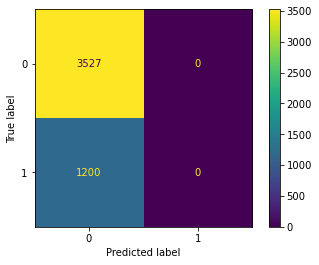

In [9]:
plot_confusion_matrix(dummy, X_test_scaled, y_test);

Baseline accuracy is 0.746

# I. Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0)

LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8022    0.9198    0.8570      3527
           1     0.5857    0.3333    0.4249      1200

    accuracy                         0.7709      4727
   macro avg     0.6939    0.6265    0.6409      4727
weighted avg     0.7472    0.7709    0.7473      4727



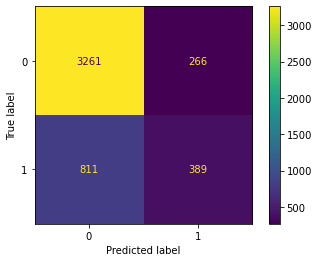

In [11]:
plot_confusion_matrix(LR, X_test_scaled, y_test);

This model performs somewhat better than the baseline. Next, I'll try to optimize performance with Grid Search cross validation

In [21]:
# Make pipeline
LR_pipeline = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

# Define parameters
params_LR = {
    'LR__C': [0.001, 0.1, 1, 10, 100],
    'LR__penalty': ['l2', 'l1'],
    'LR__solver': ['liblinear'],
    'LR__class_weight': [None, 'balanced']
}

In [52]:
%%time

scoring= ['accuracy', 'roc_auc', 'neg_log_loss']

gridcv_LR = GridSearchCV(LR_pipeline, param_grid=params_LR, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)
gridcv_LR.fit(X_train, y_train)

Wall time: 9.65 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'LR__C': [0.001, 0.1, 1, 10, 100],
                         'LR__class_weight': [None, 'balanced'],
                         'LR__penalty': ['l2', 'l1'],
                         'LR__solver': ['liblinear']},
             refit='accuracy', scoring=['accuracy', 'roc_auc', 'neg_log_loss'])

In [53]:
gridcv_LR.best_estimator_, gridcv_LR.best_params_, gridcv_LR.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR', LogisticRegression(C=0.001, solver='liblinear'))]),
 {'LR__C': 0.001,
  'LR__class_weight': None,
  'LR__penalty': 'l2',
  'LR__solver': 'liblinear'},
 0.7806219993407686)

In [54]:
LR_best = gridcv_LR.best_estimator_

y_pred = LR_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8078    0.9152    0.8582      3527
           1     0.5910    0.3600    0.4474      1200

    accuracy                         0.7743      4727
   macro avg     0.6994    0.6376    0.6528      4727
weighted avg     0.7528    0.7743    0.7539      4727



The optimized logistic regression model performs about the same as the one with default settings.

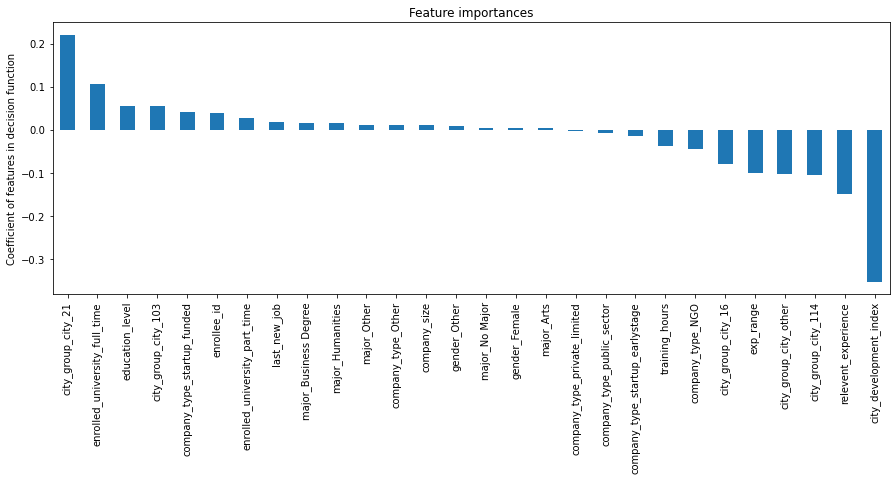

In [55]:
# Plot feature importance

importance = LR_best.named_steps.LR.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

In [58]:
for i,v in zip(feat_imp.index, feat_imp):
    print(i,':', round(v, 3))

city_group_city_21 : 0.22
enrolled_university_full_time : 0.106
education_level : 0.056
city_group_city_103 : 0.055
company_type_startup_funded : 0.041
enrollee_id : 0.038
enrolled_university_part_time : 0.028
last_new_job : 0.019
major_Business Degree : 0.016
major_Humanities : 0.015
major_Other : 0.011
company_type_Other : 0.01
company_size : 0.01
gender_Other : 0.009
major_No Major : 0.004
gender_Female : 0.004
major_Arts : 0.003
company_type_private_limited : -0.004
company_type_public_sector : -0.007
company_type_startup_earlystage : -0.015
training_hours : -0.037
company_type_NGO : -0.045
city_group_city_16 : -0.081
exp_range : -0.1
city_group_city_other : -0.103
city_group_city_114 : -0.104
relevent_experience : -0.149
city_development_index : -0.353


It seems nearly a third of the features have close to 0 impact in the model.

# II. Random Forest Classifier

In [15]:
RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3527
           1       0.56      0.37      0.45      1200

    accuracy                           0.77      4727
   macro avg       0.69      0.64      0.65      4727
weighted avg       0.75      0.77      0.75      4727



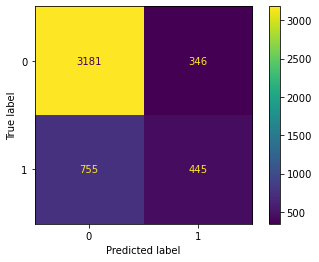

In [17]:
plot_confusion_matrix(RF, X_test_scaled, y_test);

# III. Gradient Boost Classifier

In [18]:
GB = GradientBoostingClassifier(random_state=0)

GB.fit(X_train_scaled, y_train)
y_pred = GB.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3527
           1       0.58      0.42      0.49      1200

    accuracy                           0.78      4727
   macro avg       0.70      0.66      0.67      4727
weighted avg       0.76      0.78      0.76      4727



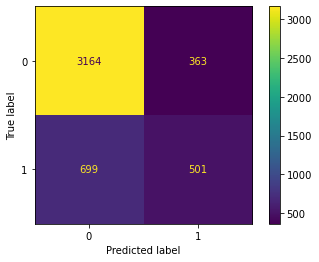

In [19]:
plot_confusion_matrix(GB, X_test_scaled, y_test);

# IV. XGBoost Model

In [29]:
XGB = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

XGB.fit(X_train_scaled, y_train)
y_pred = XGB.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

C:\Users\divzu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3527
           1       0.57      0.39      0.46      1200

    accuracy                           0.77      4727
   macro avg       0.69      0.64      0.66      4727
weighted avg       0.75      0.77      0.75      4727



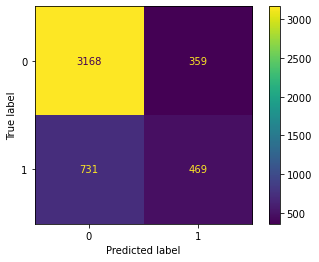

In [30]:
plot_confusion_matrix(XGB, X_test_scaled, y_test);